# Modules

In [ ]:
%%capture
!pip install gwpy
!pip install gwosc # provides an interface to querying the open data releases hosted on https://gwosc.org
!pip install nds2utils

In [ ]:
from gwosc import datasets
from gwosc.api import fetch_event_json
from gwosc.locate import get_event_urls,get_urls
from gwosc.timeline import get_segments,timeline_url
from gwpy.timeseries import TimeSeries,StateTimeSeries,StateVector
from gwpy.segments import Segment,DataQualityFlag
from gwpy.signal import filter_design
from gwpy.plot import Plot

In [ ]:
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

## Util-Functions

In [ ]:
def ISOtoGPS(isoTime:str)->int or float:
  utc = datetime.fromisoformat(isoTime.replace("Z","+00:00"))
  gpsEpoch = datetime(1980,1,6,0,0,0)+timedelta(seconds=19)
  timeDifference = utc-gpsEpoch
  gps = timeDifference.total_seconds()
  return gps

In [ ]:
def GPStoISO(gps:int or float)->str:
  gpsEpoch = datetime(1980,1,6,0,0,0)
  utc = gpsEpoch+timedelta(seconds=gps)
  iso = utc.strftime("%Y-%m-%dT%H:%M:%S")
  return iso

In [ ]:
def CurrenttoISO()->str:
  current = datetime.now()
  iso = current.isoformat()
  return iso

# Data Query Example

In [ ]:
detector = "H1"
gps = 1187008882
iso = GPStoISO(gps)
print(f"GPS Time: {gps}\nISO Time: {iso}")

GPS Time: 1187008882
ISO Time: 2017-08-17T12:41:22


In [ ]:
event = datasets.event_at_gps(gps)
print(f"Event: {event}")

Event: GW170817


In [ ]:
eventTimeInterval = datasets.event_segment(event)
print(f"Time Start: {eventTimeInterval[0]}\nTime End: {eventTimeInterval[1]}")

Time Start: 1187006835
Time End: 1187010931


In [ ]:
dataURL = get_urls(detector,eventTimeInterval[0],eventTimeInterval[1])
print(f"Data:\n{dataURL}")

Data:
['https://gwosc.org/eventapi/json/GWTC-1-confident/GW170817/v3/H-H1_GWOSC_4KHZ_R1-1187008867-32.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW170817/v3/H-H1_GWOSC_4KHZ_R1-1187006835-4096.hdf5']


# Default Data Query

In [ ]:
detector = "H1"
timeStart = "2010-09-16T06:40:00"
timeEnd = "2010-09-16T06:50:00"

In [ ]:
gpsStart = ISOtoGPS(timeStart)
gpsEnd = ISOtoGPS(timeEnd)

In [ ]:
eventsDataURL = get_urls(detector=detector,start=gpsStart,end=gpsEnd)

In [ ]:
eventsDataURL

['https://gwosc.org/archive/data/S6/967835648/H-H1_LOSC_4_V1-968650752-4096.hdf5',
 'https://gwosc.org/archive/data/S6/967835648/H-H1_LOSC_4_V1-968654848-4096.hdf5']

In [ ]:
for time in range(int(gpsStart-100),int(gpsStart+100)):
  try:
    event = datasets.event_at_gps(float(time))
    break
  except:
    pass

In [ ]:
print(f"Event Name: {event}")

Event Name: GW170817


In [ ]:
gwData = TimeSeries.fetch_open_data(detector,gpsStart,gpsEnd)

In [ ]:
gwData.shape

(2457600,)

# Spectrogram

## Simple Overview

In [ ]:
spectrogram = gwData.spectrogram(20,fftlength=8,overlap=4)**(1/2.0)

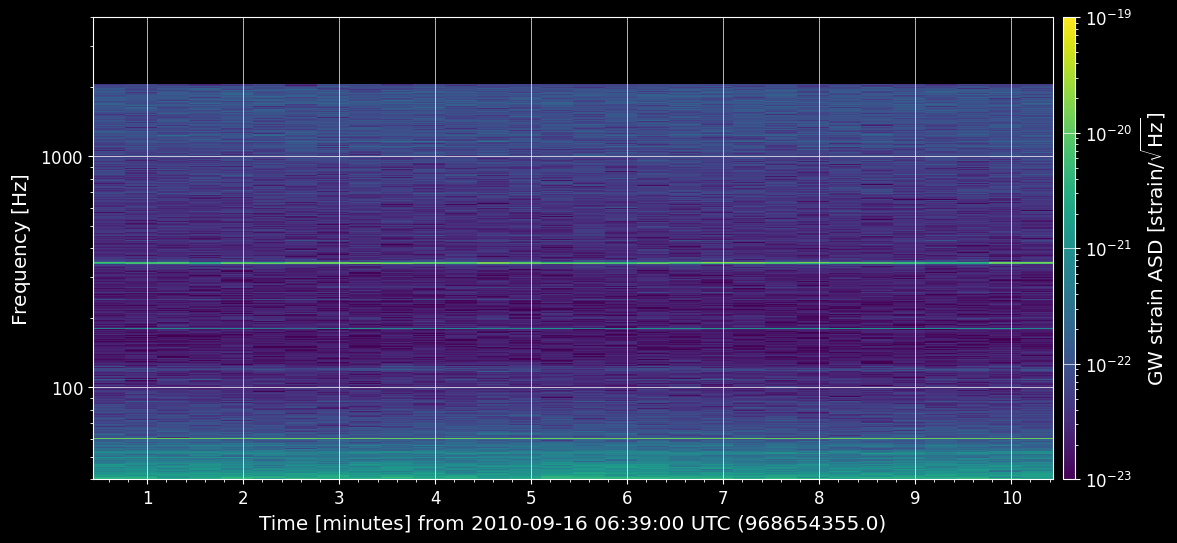

In [ ]:
plotSpectrogram = spectrogram.plot(norm="log",vmin=1e-23,vmax=1e-19)
ax = plotSpectrogram.gca()
ax.set_ylim(40,4000)
ax.set_yscale("log")
ax.colorbar(label="GW strain ASD [strain/$\sqrt{\mathrm{Hz}}$]")
plotSpectrogram.show()

## Filter Overview - Strain

In [ ]:
flow = 20 # lower corner frequency of pass band
fHigh = 350 # upper corner frequency of pass band

In [ ]:
print(f"Data Sample Rate: {gwData.sample_rate}")

Data Sample Rate: 4096.0 Hz


In [ ]:
bandpassFilter = filter_design.bandpass(flow,fHigh,gwData.sample_rate)
notches = [filter_design.notch(line,gwData.sample_rate) for line in (60,120,180)]
zpk = filter_design.concatenate_zpks(bandpassFilter,*notches)

In [ ]:
gwFilter = gwData.filter(zpk,filtfilt=True)

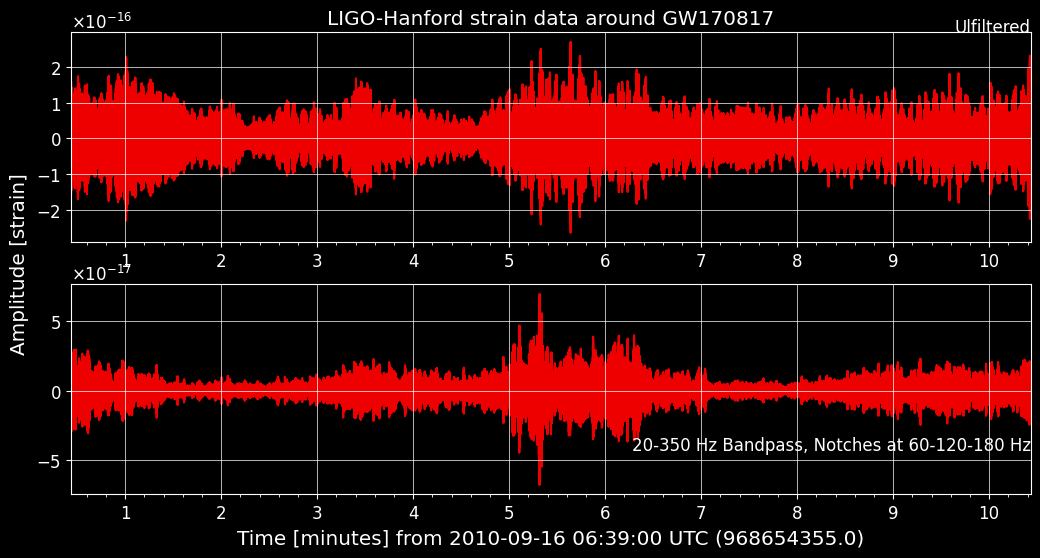

In [ ]:
plotGeneral = Plot(gwData,gwFilter,figsize=[12,6],separate=True,sharex=True,color="gwpy:ligo-hanford")
ax1,ax2 = plotGeneral.axes
ax1.set_title(f"LIGO-Hanford strain data around {event}")
ax1.set_ylabel("Amplitude [strain]",y=-0.1)
ax1.text(1.0,1.0,"Ulfiltered",transform=ax1.transAxes,ha="right")
ax2.set_ylabel("")
ax2.text(1.0,0.21,f"{flow}-{fHigh} Hz Bandpass, Notches at 60-120-180 Hz",transform=ax2.transAxes,ha="right")
plotGeneral.show()

# State Vectors - Data Quality

**A large quantity of important data from gravitational-wave detectors can be distilled into simple boolean (True or False) statements informing something about the state of the instrument at a given time. These statements can be used to identify times during which a particular control system was active, or when the signal in a seismometer was above an alarming threshold, for example.**

## Example

In [ ]:
exampleGPS = 1064534416
exampleISO = GPStoISO(exampleGPS)
print(f"GPS: {exampleGPS}\nISO: {exampleISO}")

GPS: 1064534416
ISO: 2013-09-30T00:00:16


In [ ]:
stateExample = StateTimeSeries(
    [True,True,False,False,False,True,False],
    sample_rate=1,
    epoch=exampleGPS
)

In [ ]:
print(stateExample)

StateTimeSeries([ True,  True, False, False, False,  True, False]
                unit: dimensionless,
                t0: 1064534416.0 s,
                dt: 1.0 s,
                name: None,
                channel: None)


In [ ]:
powerDetectorID = "H1"
startGPS = 1186741850
endGPS = 1186741870

In [ ]:
laserPowerData = TimeSeries.fetch_open_data(
    powerDetectorID,
    startGPS,
    endGPS
)

In [ ]:
print(laserPowerData)

TimeSeries([8.56104968e-20, 1.09045831e-19, 8.72133498e-20, ...,
            3.24891213e-19, 3.66973892e-19, 3.43180288e-19]
           unit: dimensionless,
           t0: 1186741850.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


In [ ]:
print(laserPowerData.unit)

In [ ]:
threshold = 29.2>laserPowerData.unit

In [ ]:
aboveThreshold = laserPowerData>threshold

In [ ]:
aboveThreshold

<StateTimeSeries([False, False, False, ..., False, False, False]
                 unit=Unit(dimensionless),
                 t0=<Quantity 1.18674185e+09 s>,
                 dt=<Quantity 0.00024414 s>,
                 name='Strain > True',
                 channel=None)>

In [ ]:
segmentData = aboveThreshold.to_dqflag(round=True)

In [ ]:
print(segmentData)

<DataQualityFlag('Strain > True',
                 known=[[1186741850.0 ... 1186741870.0)]
                 active=[]
                 description=None)>


## Event-GPS

In [ ]:
gps = datasets.event_gps("GW200105_162426")

In [ ]:
gps

1262276684.0

In [ ]:
startGPS = gps-1000
endGPS = gps+1000

In [ ]:
detector = "L1"

**the first detection of a mixed black hole/neutron star binary system:**

In [ ]:
stateVector = StateVector.fetch_open_data(detector,startGPS,endGPS)

In [ ]:
print(stateVector)

StateVector([127, 127, 127, ..., 127, 127, 127]
            unit: dimensionless,
            t0: 1262275684.0 s,
            dt: 1.0 s,
            name: Data quality,
            channel: None,
            bits: Bits(0: Passes DATA test
                        1: Passes CBC_CAT1 test
                        2: Passes CBC_CAT2 test
                        3: Passes CBC_CAT3 test
                        4: Passes BURST_CAT1 test
                        5: Passes BURST_CAT2 test
                        6: Passes BURST_CAT3 test,
                        channel=None,
                        epoch=1262274636.0))


**As can be seen, the list of bits is represented through the BitMask class, recording the bits as a list with some metdata about their purpose.**

In [ ]:
flags = stateVector.to_dqflags()

In [ ]:
print(flags)

DataQualityDict([('Passes DATA test', <DataQualityFlag('Passes DATA test',
                 known=[[1262275684.0 ... 1262277684.0)]
                 active=[[1262275684.0 ... 1262277684.0)]
                 description=None)>), ('Passes CBC_CAT1 test', <DataQualityFlag('Passes CBC_CAT1 test',
                 known=[[1262275684.0 ... 1262277684.0)]
                 active=[[1262275684.0 ... 1262277684.0)]
                 description=None)>), ('Passes CBC_CAT2 test', <DataQualityFlag('Passes CBC_CAT2 test',
                 known=[[1262275684.0 ... 1262277684.0)]
                 active=[[1262275684.0 ... 1262277684.0)]
                 description=None)>), ('Passes CBC_CAT3 test', <DataQualityFlag('Passes CBC_CAT3 test',
                 known=[[1262275684.0 ... 1262277684.0)]
                 active=[[1262275684.0 ... 1262277684.0)]
                 description=None)>), ('Passes BURST_CAT1 test', <DataQualityFlag('Passes BURST_CAT1 test',
                 known=[[1262275684.0 ... 126

In [ ]:
passesBURSTCAT3Test = flags["Passes BURST_CAT3 test"]

In [ ]:
passesBURSTCAT3Test

<DataQualityFlag('Passes BURST_CAT3 test',
                 known=[[1262275684.0 ... 1262277684.0)]
                 active=[[1262275684.0 ... 1262276525.0)
                         [1262276527.0 ... 1262277684.0)]
                 description=None)>

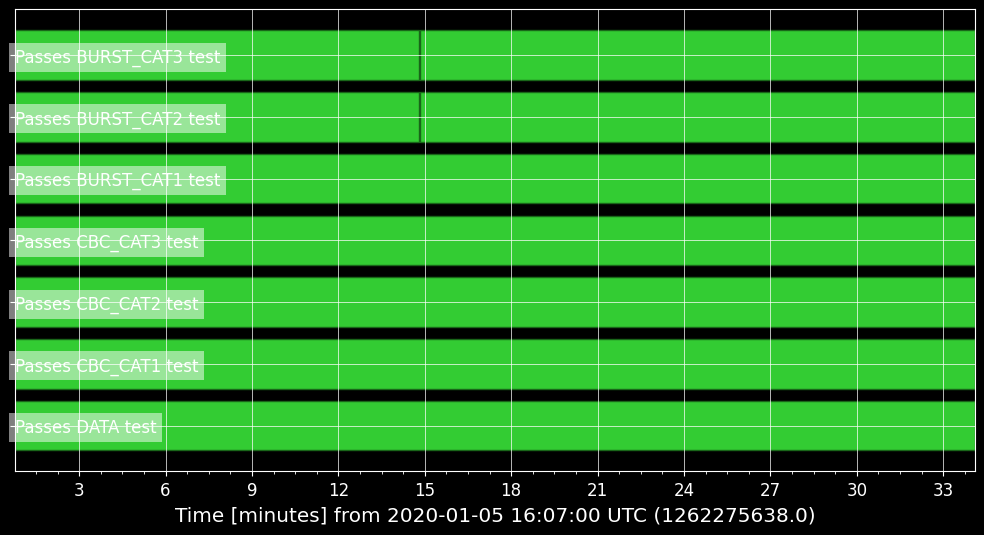

In [ ]:
plot = stateVector.plot(insetlabels=True)
plot.show()

**In this figure the black vertical lines (actually very dark green) show visually the short interval where both the BURST_CAT2 and BURST_CAT3 data-quality checks failed, just over 2 minutes prior to the GW200102 event detection.**

**A DataQualityFlag is an annotated set of segments that indicate something about instrumental operation. Each flag is defined by applying some algorithm on data and generating a SegmentList that indicates some good or bad condition has been met during those times. For example, the times during which the LIGO interferometers are operating under observing conditions are recorded as the ‘analysis-ready’ flag, which is used by data analysis groups to define periods of data over which to search for gravitational-wave signals. Conversely, high seismic noise around the observatory buildings is recorded in a data-quality flag used by those groups to veto periods of analysis as a result of sub-standard data.**

Each DataQualityFlag has some key attributes:

- The name associated with this flag: [name]
- The set of segments during which this flag was known, and its state was well defined: [known]
- The set of segments during which this flag was active [active]

In [ ]:
gwQualityData = DataQualityFlag.fetch_open_data("H1_DATA","Jan 1 2010","Jan 2 2010")

In [ ]:
print(gwQualityData)

<DataQualityFlag('H1:DATA',
                 known=[[946339215 ... 946425615)]
                 active=[[946340946 ... 946351799)
                         [946356479 ... 946360619)
                         [946362652 ... 946369149)
                         [946372854 ... 946382629)
                         [946395595 ... 946396750)
                         [946400173 ... 946404976)
                         [946412312 ... 946413576)
                         [946415770 ... 946422985)]
                 description=None)>
